# Introduction

In this notebook, we carry out the Transfer Learning Experiments.
The other notebooks, as well as the thesis can be found at https://github.com/fridowicke/infant_cries

# Imports

In [ ]:
import tensorflow as tf
import numpy as np
from google.colab import drive
import json

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

# Loading the Data

## Mount the Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Save / Load Processed Data

In [ ]:
#We use json to save the spectrograms and f0s of the produced data in order to avoid computing them every time we use the notebook.
#Helper functions
def save(data, filename):
    if type(data) is np.ndarray:
      data = data.tolist()
    with open(filename, 'w') as f:
        json.dump(data, f, ensure_ascii=False)
        
def load(filename):
    with open(filename) as data:
        x = json.load(data)
    return np.array(x)

In [ ]:
#Load the Data
specs_train = load("/content/drive/My Drive/infant_cries/data_js_final/specs_train.json")
y_train = load("/content/drive/My Drive/infant_cries/data_js_final/y_train.json")
specs_dev_ger = load("/content/drive/My Drive/infant_cries/data_js_final/specs_dev_ger.json")
specs_dev_jap = load("/content/drive/My Drive/infant_cries/data_js_final/specs_dev_jap.json")
specs_test_ger = load("/content/drive/My Drive/infant_cries/data_js_final/specs_dev_ger.json")
specs_test_jap = load("/content/drive/My Drive/infant_cries/data_js_final/specs_dev_jap.json")
specs_eval = load("/content/drive/My Drive/infant_cries/data_js_final/specs_eval.json")
X_dev_ger = load("/content/drive/My Drive/infant_cries/data_js_final/X_dev_ger.json")
X_dev_jap = load("/content/drive/My Drive/infant_cries/data_js_final/X_dev_jap.json")
X_test_ger = load("/content/drive/My Drive/infant_cries/data_js_final/X_dev_ger.json")
X_test_jap = load("/content/drive/My Drive/infant_cries/data_js_final/X_dev_jap.json")
X_eval = load("/content/drive/My Drive/infant_cries/data_js_final/X_eval.json")


## Create Datasets

In [ ]:
#Size of the Dataset
n, height, width = specs_train.shape
n_dev_ger = specs_dev_ger.shape[0]
n_dev_jap = specs_dev_jap.shape[0]
n_test_ger = specs_test_ger.shape[0]
n_test_jap = specs_test_jap.shape[0]
n_eval = specs_eval.shape[0]

#Create the ys for dev and test set
y_dev_ger = np.zeros(n_dev_ger)
y_dev_jap = np.ones(n_dev_jap)
y_test_ger = np.zeros(n_test_ger)
y_test_jap = np.ones(n_test_jap)

#Reshape spectrograms for train, dev, test, eval
specs_train = specs_train.reshape([n,height,width,1])
specs_dev_ger = specs_dev_ger.reshape([n_dev_ger,height,width,1])
specs_dev_jap = specs_dev_jap.reshape([n_dev_jap,height,width,1])
specs_test_ger = specs_test_ger.reshape([n_test_ger,height,width,1])
specs_test_jap = specs_test_jap.reshape([n_test_jap,height,width,1])
specs_eval = specs_eval.reshape([n_eval,height,width,1])

#Create mixed dev set
specs_dev = np.zeros((2*n_dev_jap, height, width, 1))
specs_dev[:n_dev_jap] = specs_dev_jap
specs_dev[n_dev_jap:] = np.vstack((specs_dev_ger,specs_dev_ger,specs_dev_ger,specs_dev_ger))[:n_dev_jap]
y_dev = np.zeros(2*n_dev_jap)
y_dev[:n_dev_jap] = 1

#Create mixed test set
specs_test = np.zeros((2*n_test_jap, height, width, 1))
specs_test[:n_test_jap] = specs_test_jap
specs_test[n_test_jap:] = np.vstack((specs_test_ger,specs_test_ger,specs_test_ger,specs_test_ger))[:n_test_jap]
y_test = np.zeros(2*n_test_jap)
y_test[:n_test_jap] = 1

#Create the eval set
y_eval = np.zeros(n_eval)

#Set the Class Names
class_names = ["German", "Japanese"]

# Pretrained ResNet

## Create Dataset and function to pretrain ResNet

In [ ]:
specs_train_resnet = tf.tile(specs_train, [1,1,1,3])
specs_dev_resnet = tf.tile(specs_dev, [1,1,1,3])
specs_dev_ger_resnet = tf.tile(specs_dev_ger, [1,1,1,3])
specs_dev_jap_resnet = tf.tile(specs_dev_jap, [1,1,1,3])

specs_test_resnet = tf.tile(specs_test, [1,1,1,3])
specs_test_ger_resnet = tf.tile(specs_test_ger, [1,1,1,3])
specs_test_jap_resnet = tf.tile(specs_test_jap, [1,1,1,3])

specs_eval_resnet = tf.tile(specs_eval, [1,1,1,3])
input_shape  = (height, width,3)

In [ ]:
def pretrain_resnet():
  base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = input_shape)
  for layer in base_model.layers:
    layer.trainable = False
  x = layers.Flatten()(base_model.output)
  x = layers.Dense(1000, activation='relu')(x)
  predictions = layers.Dense(2, activation = 'softmax')(x)
  resnet_pretrained = tf.keras.Model(inputs = base_model.input, outputs = predictions)
  resnet_pretrained.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
  return resnet_pretrained



## Determine ideal number of epochs

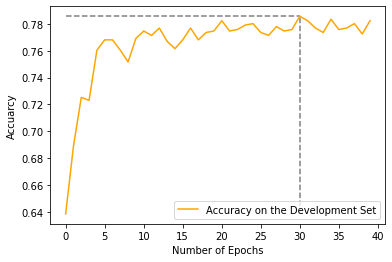

31


In [ ]:
resnet_pretrained = pretrain_resnet()
dev_accs=np.zeros(40)
for idx1 in range(5):
  resnet_pretrained = pretrain_resnet()
  for idx in range(40):
    if idx%10==0:
      print(idx1, idx)
    history = resnet_pretrained.fit(specs_train_resnet, y_train, batch_size=64, epochs=1, verbose=0)
    _, train_acc = resnet_pretrained.evaluate(specs_train_resnet, y_train, verbose=0)
    _, dev_acc = resnet_pretrained.evaluate(specs_dev_resnet, y_dev, verbose=0)
    dev_accs[idx]= dev_accs[idx]+dev_acc

dev_accs = dev_accs/5

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(40), dev_accs, color='orange', label='Accuracy on the Development Set')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuarcy')
plt.hlines(np.max(dev_accs), 0, np.argmax(dev_accs), colors='grey', linestyles='dashed')
plt.vlines(np.argmax(dev_accs), np.min(dev_accs), np.max(dev_accs), colors='grey', linestyles='dashed')
plt.legend(loc='lower right')
plt.show()

num_epochs = np.argmax(dev_accs)+1
print(num_epochs)

## Test Pretrained ResNet with optimal Parameters

In [ ]:
accs_dev_ResNet  = []
accs_test_ResNet = []
fscore_eval_ResNet   = []

for idx in range(100):
  print(idx)
  ResNet = pretrain_resnet()
  ResNet.fit(specs_train_resnet, y_train, batch_size=64, epochs=num_epochs, verbose=0)
  _, acc_dev_ger = ResNet.evaluate(specs_dev_ger_resnet, y_dev_ger, verbose=0)
  _, acc_dev_jap = ResNet.evaluate(specs_dev_jap_resnet, y_dev_jap, verbose=0)
  _, acc_test_ger = ResNet.evaluate(specs_test_ger_resnet, y_test_ger, verbose=0)
  _, acc_test_jap = ResNet.evaluate(specs_test_jap_resnet, y_test_jap, verbose=0)
  _, acc_eval = ResNet.evaluate(specs_eval_resnet, y_eval, verbose=0)
  acc_dev  = (acc_dev_ger+acc_dev_jap)/2
  acc_test = (acc_test_ger+acc_test_jap)/2
  accs_dev_ResNet.append(acc_dev)
  accs_test_ResNet.append(acc_test)
  fscore_eval_ResNet.append(2*(acc_eval)/(1+acc_eval))

save(accs_dev_ResNet,"/content/drive/My Drive/infant_cries/data_js_final/accs_dev_ResNet.json")
save(accs_test_ResNet,"/content/drive/My Drive/infant_cries/data_js_final/accs_test_ResNet.json")
save(fscore_eval_ResNet,"/content/drive/My Drive/infant_cries/data_js_final/fscore_eval_ResNet.json")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
accs_dev_ResNet      = load("/content/drive/My Drive/infant_cries/data_js_final/accs_dev_ResNet.json")
accs_test_ResNet     = load ("/content/drive/My Drive/infant_cries/data_js_final/accs_test_ResNet.json")
fscore_eval_ResNet   = load("/content/drive/My Drive/infant_cries/data_js_final/fscore_eval_ResNet.json")

Mean:0.7740110024809838, Min:0.7362637519836426, Max:0.8131868243217468
50th percentile. 0.7747252881526947


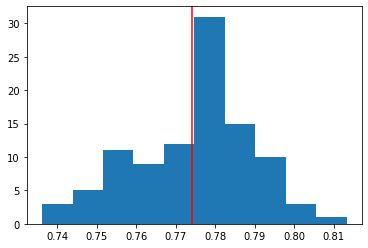

In [ ]:
print(f"Mean:{np.mean(accs_dev_ResNet)}, Min:{np.min(accs_dev_ResNet)}, Max:{np.max(accs_dev_ResNet)}")
print(f"50th percentile. {np.percentile(accs_dev_ResNet, 50)}")
plt.hist(accs_dev_ResNet)
plt.axvline(np.mean(accs_dev_ResNet), color='red')
plt.show()

Mean:0.7740110024809838, Min:0.7362637519836426, Max:0.8131868243217468


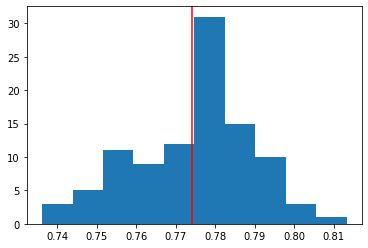

In [ ]:
print(f"Mean:{np.mean(accs_test_ResNet)}, Min:{np.min(accs_test_ResNet)}, Max:{np.max(accs_test_ResNet)}")
plt.hist(accs_test_ResNet)
plt.axvline(np.mean(accs_test_ResNet), color='red')
plt.show()

Mean:0.6809957085095268, Min:0.5986394523730232, Max:0.7204968773570444


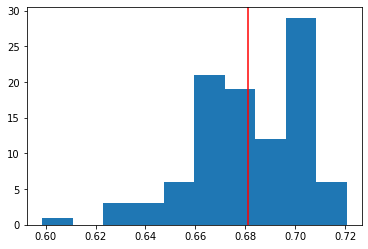

In [ ]:
print(f"Mean:{np.mean(fscore_eval_ResNet)}, Min:{np.min(fscore_eval_ResNet)}, Max:{np.max(fscore_eval_ResNet)}")
plt.hist(fscore_eval_ResNet)
plt.axvline(np.mean(fscore_eval_ResNet), color='red')
plt.show()

# Pretrained EffNet

## Create function to obtain the pretrained EffNet

In [ ]:
def pretrain_effnet():
  base_model = tf.keras.applications.EfficientNetV2S(weights = 'imagenet', include_top = False, input_shape = input_shape)
  for layer in base_model.layers:
    layer.trainable = False
  x = layers.Flatten()(base_model.output)
  x = layers.Dense(1000, activation='relu')(x)
  predictions = layers.Dense(2, activation = 'softmax')(x)
  effnet_pretrained = tf.keras.Model(inputs = base_model.input, outputs = predictions)
  effnet_pretrained.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
  return effnet_pretrained

## Determine ideal number of epochs

0 0
0 10
0 20
0 30
1 0
1 10
1 20
1 30
2 0
2 10
2 20
2 30
3 0
3 10
3 20
3 30
4 0
4 10
4 20
4 30


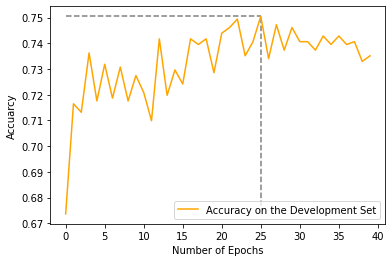

26


In [ ]:
effnet_pretrained = pretrain_effnet()

dev_accs=np.zeros(40)
for idx1 in range(5):
  effnet_pretrained = pretrain_effnet()
  for idx in range(40):
    if idx%10==0:
      print(idx1, idx)
    history = effnet_pretrained.fit(specs_train_resnet, y_train, batch_size=64, epochs=1, verbose=0)
    _, train_acc = effnet_pretrained.evaluate(specs_train_resnet, y_train, verbose=0)
    _, dev_acc = effnet_pretrained.evaluate(specs_dev_resnet, y_dev, verbose=0)
    dev_accs[idx]= dev_accs[idx]+dev_acc

dev_accs = dev_accs/5

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(40), dev_accs, color='orange', label='Accuracy on the Development Set')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuarcy')
plt.hlines(np.max(dev_accs), 0, np.argmax(dev_accs), colors='grey', linestyles='dashed')
plt.vlines(np.argmax(dev_accs), np.min(dev_accs), np.max(dev_accs), colors='grey', linestyles='dashed')
plt.legend(loc='lower right')
plt.show()

num_epochs = np.argmax(dev_accs)+1
print(num_epochs)

## Test Pretrained EffNet with optimal Parameters

In [ ]:
accs_dev_EffNet  = []
accs_test_EffNet = []
fscore_eval_EffNet   = []

for idx in range(100):
  print(idx)
  EffNet = pretrain_effnet()
  EffNet.fit(specs_train_resnet, y_train, batch_size=64, epochs=num_epochs, verbose=0)
  _, acc_dev_ger = EffNet.evaluate(specs_dev_ger_resnet, y_dev_ger, verbose=0)
  _, acc_dev_jap = EffNet.evaluate(specs_dev_jap_resnet, y_dev_jap, verbose=0)
  _, acc_test_ger = EffNet.evaluate(specs_test_ger_resnet, y_test_ger, verbose=0)
  _, acc_test_jap = EffNet.evaluate(specs_test_jap_resnet, y_test_jap, verbose=0)
  _, acc_eval = EffNet.evaluate(specs_eval_resnet, y_eval, verbose=0)
  acc_dev  = (acc_dev_ger+acc_dev_jap)/2
  acc_test = (acc_test_ger+acc_test_jap)/2
  accs_dev_EffNet.append(acc_dev)
  accs_test_EffNet.append(acc_test)
  fscore_eval_EffNet.append(2*(acc_eval)/(1+acc_eval))

save(accs_dev_EffNet,"/content/drive/My Drive/infant_cries/data_js_final/accs_dev_EffNet.json")
save(accs_test_EffNet,"/content/drive/My Drive/infant_cries/data_js_final/accs_test_EffNet.json")
save(fscore_eval_EffNet,"/content/drive/My Drive/infant_cries/data_js_final/fscore_eval_EffNet.json")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
accs_dev_EffNet  = load("/content/drive/My Drive/infant_cries/data_js_final/accs_dev_EffNet.json")
accs_test_EffNet = load ("/content/drive/My Drive/infant_cries/data_js_final/accs_test_EffNet.json")
fscore_eval_EffNet   = load("/content/drive/My Drive/infant_cries/data_js_final/fscore_eval_EffNet.json")

Mean:0.7453296855092049, Min:0.7087912261486053, Max:0.7802197933197021
50th percentile. 0.7472527623176575


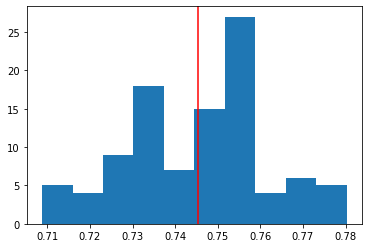

In [ ]:
print(f"Mean:{np.mean(accs_dev_EffNet)}, Min:{np.min(accs_dev_EffNet)}, Max:{np.max(accs_dev_EffNet)}")
print(f"50th percentile. {np.percentile(accs_dev_EffNet, 50)}")
plt.hist(accs_dev_EffNet)
plt.axvline(np.mean(accs_dev_EffNet), color='red')
plt.show()

Mean:0.7453296855092049, Min:0.7087912261486053, Max:0.7802197933197021


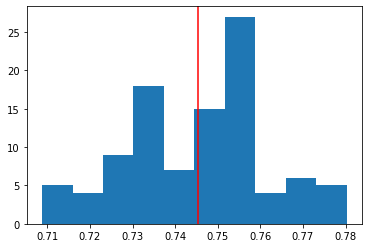

In [ ]:
print(f"Mean:{np.mean(accs_test_EffNet)}, Min:{np.min(accs_test_EffNet)}, Max:{np.max(accs_test_EffNet)}")
plt.hist(accs_test_EffNet)
plt.axvline(np.mean(accs_test_EffNet), color='red')
plt.show()

Mean:0.72101389024702, Min:0.6266666759437984, Max:0.7953216256694506


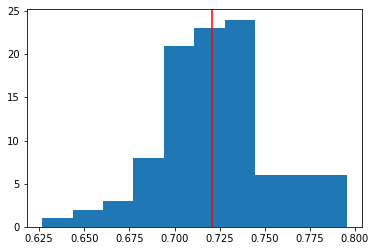

In [ ]:
print(f"Mean:{np.mean(fscore_eval_EffNet)}, Min:{np.min(fscore_eval_EffNet)}, Max:{np.max(fscore_eval_EffNet)}")
plt.hist(fscore_eval_EffNet)
plt.axvline(np.mean(fscore_eval_EffNet), color='red')
plt.show()